In [19]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from ballbeam.paths import ROOT_PATH
from ballbeam.common import mspc

In [20]:
def load_log_data(path):
    with path.open() as f:
        log_data = json.load(f)
    return pd.DataFrame(log_data)


data = {}
# for path in (ROOT_PATH / "data" / "standard" / "aligned").glob("*.json"):
for experiment_name in ["tmp"]:
# for experiment_name in ["random"]:
# for experiment_name in ["random_waves_with_inactive"]:
# for experiment_name in ["random", "random_waves_with_inactive"]:
# for experiment_name in ["lqr_explore_inactive", "random_waves_with_inactive"]:
# for experiment_name in ["random_waves", "lqr_explore_inactive", "random_waves_with_inactive"]:
    for path in (ROOT_PATH / "data" / experiment_name).glob("*.json"):
    # for path in (ROOT_PATH / "data" / experiment_name / "truncated").glob("*.json"):
        key = path.stem
        df = load_log_data(path)
        max_obs = df.observation.abs().max()
        # Drop examples where the observation blew up. Garbage.
        if max_obs > 0.1:
            print(f"Skipping {key} due to excessive max observation {max_obs:6.3f}")
            continue
        data[key] = df

Skipping 1750014333580124160 due to excessive max observation  0.115
Skipping 1762193624615545600 due to excessive max observation  0.110
Skipping 1762194575631030784 due to excessive max observation  0.115


In [21]:
obs_df = pd.DataFrame({key: df.observation for key, df in data.items()})
act_df = pd.DataFrame({key: df.action for key, df in data.items()})
spt_df = pd.DataFrame({key: df.setpoint for key, df in data.items()})

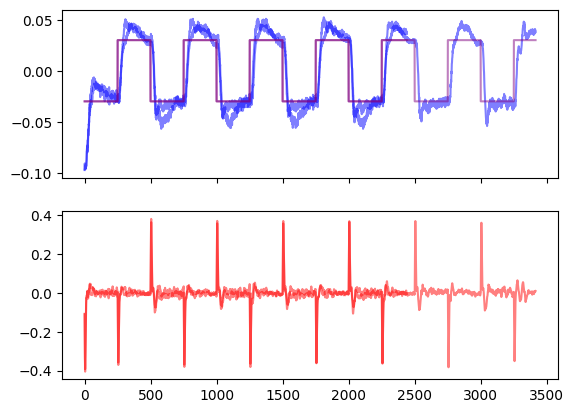

In [22]:
# NOTE: shift Y, S one step forward relative to U to account for logging format
Y = (obs_df.to_numpy().T)[:, 1:]
U = (act_df.to_numpy().T)[:, 0:-1]
S = (spt_df.to_numpy().T)[:, 1:]

fig, axs = plt.subplots(nrows=2, sharex=True)
alpha = np.clip(1.0 / Y.shape[0], 0.001, 1.0)
axs[0].plot(Y.T, c="blue", alpha=alpha)
axs[0].plot(S.T, c="purple", alpha=alpha)
axs[1].plot(U.T, c="red", alpha=alpha)
plt.show()

In [23]:
dt = df.time_since_last.mean().round(3)

past_sec = 2.0
futr_sec = 1.0

# past_sec = 1.0
# futr_sec = 0.5

past = int(past_sec / dt)
futr = int(futr_sec / dt)
horizons = mspc.Horizons(past, futr)

In [24]:
predictor = mspc.MultiStepPredictor(horizons)
U_trn = U.copy()
Y_trn = Y.copy()

# # Add random noise for training to help prevent overfitting
U_trn += 0.050 * np.random.uniform(low=-1, high=1, size=U_trn.shape)
Y_trn += 0.005 * np.random.uniform(low=-1, high=1, size=Y_trn.shape)

predictor.fit(U_trn, Y_trn)

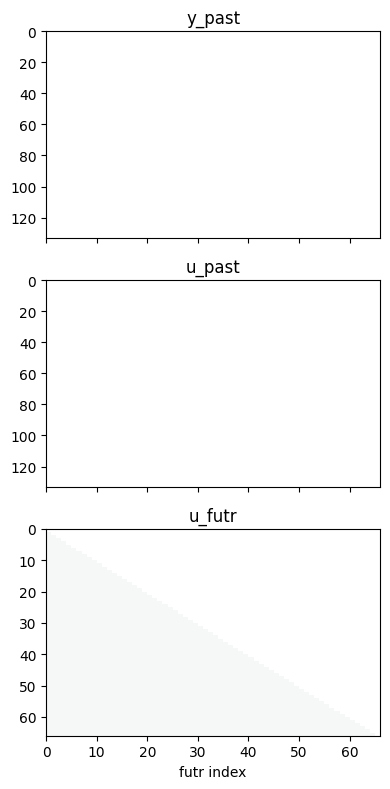

In [25]:
from typing import Any

def params_plot(params: mspc.MultiStepPredictorParams) -> tuple[plt.Figure, Any]:
    fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(4, 8))
    # axs[0].pcolormesh(np.flipud(params.theta_y_past), vmin=-0.5, vmax=0.5, cmap="RdBu")
    # axs[1].pcolormesh(np.flipud(params.theta_u_past), vmin=-0.05, vmax=0.05, cmap="RdBu")
    # axs[2].pcolormesh(np.flipud(params.theta_u_futr), vmin=-0.05, vmax=0.05, cmap="RdBu")
    axs[0].pcolormesh(params.theta_y_past, vmin=-0.5, vmax=0.5, cmap="RdBu")
    axs[1].pcolormesh(params.theta_u_past, vmin=-0.05, vmax=0.05, cmap="RdBu")
    axs[2].pcolormesh(params.theta_u_futr, vmin=-0.05, vmax=0.05, cmap="RdBu")
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[2].invert_yaxis()
    axs[0].set_title("y_past")
    axs[1].set_title("u_past")
    axs[2].set_title("u_futr")
    axs[-1].set_xlabel("futr index")
    fig.tight_layout()
    return fig, axs

params_plot(predictor.params)
plt.show()

In [26]:
# Roll the input-output data
U_past_r, Y_past_r, U_futr_r, Y_futr_r = mspc.roll(U, Y, horizons)

# Predict the future
Y_futr_r_pred = predictor.predict(U_past_r, Y_past_r, U_futr_r)

# Prediction error
Y_futr_r_pred_err = np.abs(Y_futr_r_pred - Y_futr_r)

In [27]:
from matplotlib import cm

def get_fill_color(x):
    return cm.viridis(x)[0:3]

fill_colors = {0: get_fill_color(0.2), 1: get_fill_color(0.4), 5: get_fill_color(0.6), 25: get_fill_color(0.8)}

Avg error: nan


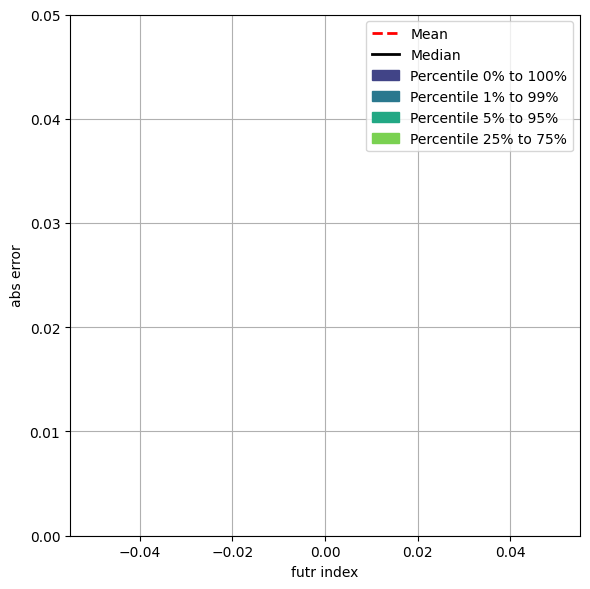

In [28]:
# Prediction error analysis
Y_futr_r_pred_err_pcts = {p: np.percentile(Y_futr_r_pred_err, p, axis=0) for p in [0, 1, 5, 25, 50, 75, 95, 99, 100]}
                                      
print(f"Avg error: {np.mean(Y_futr_r_pred_err_pcts[50]):.4f}")

fig, axs = plt.subplots(figsize=(6, 6))
futr_idxs = np.arange(predictor.horizons.futr)

plt.plot(futr_idxs, np.mean(Y_futr_r_pred_err, axis=0), color="r", lw=2, label="Mean", linestyle="--")
plt.plot(futr_idxs, Y_futr_r_pred_err_pcts[50], color="k", lw=2, label="Median")

for p in [0, 1, 5, 25]:
    plt.fill_between(futr_idxs, Y_futr_r_pred_err_pcts[p], Y_futr_r_pred_err_pcts[100-p], color=fill_colors[p], label=f"Percentile {p}% to {100-p}%")
plt.ylim(0, 0.05)
plt.xlabel("futr index")
plt.ylabel("abs error")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [29]:
controller = mspc.MultiStepPredictiveController(
    predictor, 
    action_bounds=mspc.ActionBounds(lower=-0.4, upper=0.4), 
    action_reg=0.2, 
    action_diff_reg=2.0,
)

In [30]:
from IPython.display import HTML
from ballbeam.notebooks.predictive_control_vis import visualize
import example as ex

example_idx = 2
frame_range = np.arange(1500, 1700)

example = ex.example_from_yus(example_idx=example_idx, Y=Y, U=U, S=S)
HTML(visualize(controller, dt, example, frame_range=frame_range, engine="matplotlib"))

ModuleNotFoundError: No module named 'rerun'

In [ ]:
from ballbeam.paths import CONFIGURATION_PATH
controller.to_file_path(CONFIGURATION_PATH / "controller/mspc/controller_params.npz")